# **Diagnosing Diabetic Retinopathy**
### **Ben Chrepta and Fariha Tamboli**

#Part 0: Imports

In [ ]:
#full imports on Fariha-FinalProject

# Part 1: Load the Dataset from Kaggle
For some reason, you have to run this twice to get it to work

Reference: https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463 

In [ ]:
#source: https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463
!pip install --upgrade kaggle
!mkdir .kaggle

import json
token = {'username':'ftamboli','key':'f332d8730eb66bc382fdd2c2167c658b'}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list

!kaggle datasets list -s dr

!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized -p /content

In [ ]:
!unzip \*.zip

#Part 2: Formatting/Visualizing the Images

In [ ]:
#0 is no DR, 1 is DR (of any level)
from google.colab import drive
drive.mount('/content/drive')


df_train = pd.read_csv('/content/trainLabels_nice.csv')

df_train['level'] = df_train['level'].apply(lambda x: 1 if x!= 0 else 0)

print(df_train.columns)

x = df_train['image']
y = df_train['level']

x, y = shuffle(x, y, random_state=75)

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.2,
                                                      stratify=y, random_state=75)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

##Crop images

Here, we introduce three different ideas for cropping our images. We will choose the bright crop, since there is more contrast in the images.


Reference: These ideas are originally from @xhlulu on Kaggle. 

https://www.kaggle.com/xhlulu/aptos-2019-densenet-keras-starter



In [ ]:
#@title Simple Crop
#@markdown Crop out all the black border
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['level'] == class_id].sample(5, random_state=75).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/resized_train_cropped/resized_train_cropped/{row['image']}.jpeg"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512,512))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['level']) )

In [ ]:
#@title Black and White crop
#@markdown Build on the Simple Crop, then greyscale
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['level'] == class_id].sample(5, random_state=75).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/resized_train_cropped/resized_train_cropped/{row['image']}.jpeg"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512,512))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 512/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['image']) )

In [ ]:
#@title Bright Crop
#@markdown Change the illumination. Build on the Simple Crop
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        h,w,_=img.shape
#         print(h,w)
        img1=cv2.resize(crop_image1(img[:,:,0]),(w,h))
        img2=cv2.resize(crop_image1(img[:,:,1]),(w,h))
        img3=cv2.resize(crop_image1(img[:,:,2]),(w,h))
        
#         print(img1.shape,img2.shape,img3.shape)
        img[:,:,0]=img1
        img[:,:,1]=img2
        img[:,:,2]=img3
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image(image)
    image = cv2.resize(image, (512,512))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    # print(type(image))
    return image

NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['level'] == class_id].sample(NUM_SAMP, random_state=75).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/resized_train_cropped/resized_train_cropped/{row['image']}.jpeg"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['image']) )


#create new file with all the images


##Create the Bright Crop images, make a GDrive folder, do not need to run this (its already done)

In [ ]:
#@title Choose Bright Crop, Create new file of bright crop images
#@markdown This does not need to be run. This takes more than 2 hours. This is the link of the file of converted images: https://drive.google.com/drive/folders/1AutCwMZ7T0VXl7CrOAmgJ7ATdcoLSw2s?usp=sharing 
#Run time: 2.25 hours

# import shutil
# shutil.rmtree('/content/bright_images')

!mkdir bright_images

root_dir = '/content/'
content_dir = 'resized_train_cropped/resized_train_cropped/'
for f in df_train['image']:
   file_name = content_dir + f + '.jpeg'
   img_name = os.path.join(root_dir, file_name)
   image = load_ben_color(img_name,sigmaX=30)
   
   cv2.imwrite("/content/bright_images/"+ f + ".jpeg", image)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title Take the generated images from above and put them into the google drive folder.
#@markdown This does not need to be run, since this is already done. 
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/'
content_dir = 'bright_images/'
for f in df_train['image']:
  file_name = content_dir+f+'.jpeg'
  img_name = os.path.join(root_dir, file_name)
  print(img_name)
  image = io.imread(img_name)
  cv2.imwrite('/content/drive/My Drive/drive_bright_images/' + f + '.jpeg' , image)

#Part 3: Loading Images
Create a dataset class, and pass it into a dataloader. 

Reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html 

In [ ]:
files = os.listdir('/content/resized_train_cropped/resized_train_cropped/')
print(len(files))

164

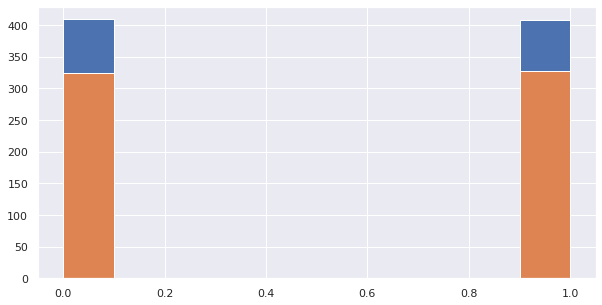

In [ ]:
#@title Visualizing the Distribution of Data
# base_image_dir = os.path.join('/content', '/')
df = pd.read_csv(os.path.join('/content/', 'trainLabels_nice.csv'))
df['path'] = df['image'].map(lambda x: os.path.join('/content/drive/MyDrive/drive_bright_images','{}.jpeg'.format(x)))
df = df.drop(columns=['image'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df['level'] = (df['level'] > 0).astype(int) # Disease or no disease
df.head(10)
train_df, val_df = train_test_split(df,test_size=0.2)
df['level'].hist(figsize = (10, 5))
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [ ]:
print(df_train)
print(df_train['level'][5])

In [ ]:
#title Dataloaders
dr_data = DRDataset(csv_file='trainLabels_cropped.csv',
                            root_dir='/content/drive/My Drive/drive_bright_images')
print(len(dr_data))
len_dr = len(dr_data)
train_size = (int)(0.8*len_dr)
test_size = len_dr - train_size
train_dr, test_dr = torch.utils.data.random_split(dr_data, [train_size, test_size])



batch_size = 10
train_loader = torch.utils.data.DataLoader(dataset=train_dr, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dr, batch_size=batch_size, shuffle=False)


fig = plt.figure()

print(dr_data)
for i in range(len(dr_data)):
    image, label = dr_data[i]

    print(image.shape, label.shape, "label: ", label)

    ax = plt.subplot(1, 6, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    sample = {'image':image, 'label': label}
    show_landmarks(**sample)

    if i == 5:
        plt.show()
        break
        

#Part 4: Non-Deep Learning Benchmark: Logistic Regression Model

In [ ]:
#on DataProccessing_and_LogisticRegression.ipynb linked below
#https://colab.research.google.com/drive/1EeOpq2oOPrqxYYFDQ81MtyQ-FBdNgOmE?usp=sharing

#Part 5: CNN

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import torch

class DRDataset(Dataset):
    def __init__ (self, csv_file, root_dir, transform=None):
        """
        csv_file = labels
        root_dir = images
        
        """
        
        self.train_data_csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.train_data_csv)

    def __getitem__ (self, idx): 
        name = self.train_data_csv.iloc[idx, 2]
        img_name = os.path.join(self.root_dir, name +'.jpeg')
        image = Image.open(img_name)
        y_labels = float(self.train_data_csv.iloc[idx, 3:])
        if y_labels == 0:
          y_labels = np.array([1,0])
        elif y_labels ==1:
          y_labels = np.array([0,1])
        else: pass
        
        if self.transform is not None:
            image = self.transform(image)
        return (image, y_labels)

In [ ]:

trainer_names_csv = pd.read_csv('/content/trainLabels_nice.csv')

n = len(trainer_names_csv)
img_names = trainer_names_csv.iloc[:n, 2]
label = trainer_names_csv.iloc[:n, 3]

print(img_names[0])
print(label[1])
def showimages(img):
    plt.imshow(img)
    
showimages(io.imread('/content/drive/MyDrive/drive_bright_images/' + img_names[0] + '.jpeg'))
print(f'Label: {label[0]}, Image_ID: {img_names[0]}')

In [ ]:

from tqdm import tqdm
import random

transform = transforms.Compose([
    transforms.ToTensor()
    ])

num_epochs = 10
learning_rate = 0.001
train_CNN = True
batch_size = 10
shuffle = True
pin_memory = True
num_workers = 0



train_size = int(0.8 * n)
validation_size = n - train_size


image_dataset = DRDataset(csv_file='/content/trainLabels_nice.csv', root_dir='/content/drive/MyDrive/drive_bright_images/')

dataset = DRDataset(csv_file='/content/trainLabels_nice.csv', root_dir='/content/drive/MyDrive/drive_bright_images/', 
                               transform=transform)


train_set, validation_set = torch.utils.data.random_split(dataset, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)




dataiter = iter(train_loader)
image, label = dataiter.next()

print(image.shape)
print(label.shape)
print(label)
print(image)


In [ ]:
class Net(nn.Module):
    def __init__ (self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.pool = nn.MaxPool2d(4, 3)

        self.fc1 = nn.Linear(6272, 512)
        self.fc2 = nn.Linear(512, 64)

        self.fc3 = nn.Linear(64, 2)
       
        self.dropout = nn.Dropout(0.2)

        self.flat = nn.Flatten()

        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)

        x = self.flat(x)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [ ]:
iter = 0
total_loss = []
total_acc = []
epochs = 10
import torch.optim as optim  
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(int(epochs)):
    print("epoch num: ", epoch)
    epoch_loss = 0
    epoch_acc = 0
    correct = 0
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(images.shape[0], -1)) #, requires_grad = True)
        labels = Variable(labels.squeeze().type(torch.DoubleTensor)) #, requires_grad = True)

        optimizer.zero_grad()
        loss = criterion(outputs.type(torch.DoubleTensor), labels)
        loss = Variable(loss, requires_grad = True)
       
        epoch_loss+=loss.item()
        outputs = net(inputs) 
        labels = labels.view(-1, 1)

        loss = criterion(outputs, labels) 
        _,predicted = torch.max(outputs.data, 1)
        new_labels = predicted.clone()
        int_it = 0
        for l in labels:
          p = l.data.cpu().numpy()[0]
          # print("p is: ", p)
          if p == 1:
            new_labels[int_it] = 0.
          elif p == 0:
            new_labels[int_it] = 1.
          else: pass
          int_it+=1

        
        correct = (predicted == new_labels).sum()
        epoch_acc += correct.data.cpu().data.tolist()

        loss.backward()
        optimizer.step()
        iter+=1
    total_loss.append(epoch_loss/len(train_loader))
    total_acc.append(epoch_acc/len(train_loader))

In [ ]:
print(epoch_loss)
print(total_loss)
print(epoch_acc)
print(total_acc)

lr_model.eval()
lr_model.to(device)
epochs = 10
plt.plot(np.linspace(1, epochs, epochs).astype(int), total_loss)


lr_model.eval()
lr_model.to(device)
epochs = 10
plt.plot(np.linspace(1, epochs, epochs).astype(int), total_acc)
plt.legend()

#Part 6: ResNet


In [ ]:

trainer_names_csv = pd.read_csv('/content/trainLabels_nice.csv')

n = len(trainer_names_csv)
img_names = trainer_names_csv.iloc[:n, 2]
label = trainer_names_csv.iloc[:n, 3]

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import torch

class DRDataset(Dataset):
    def __init__ (self, csv_file, root_dir, transform=None):
        """
        csv_file = labels
        root_dir = images
        
        """
        
        self.train_data_csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.train_data_csv)

    def __getitem__ (self, idx): 
        name = self.train_data_csv.iloc[idx, 2]
        img_name = os.path.join(self.root_dir, name +'.jpeg')
        image = Image.open(img_name)
        y_labels = float(self.train_data_csv.iloc[idx, 3:])
        if y_labels == 0:
          y_labels = np.array([1,0])
        elif y_labels ==1:
          y_labels = np.array([0,1])
        else: pass
        
        if self.transform is not None:
            image = self.transform(image)
        return (image, y_labels)

In [ ]:
from tqdm import tqdm
import random

transform = transforms.Compose([
    transforms.ToTensor()   
])

num_epochs = 10
learning_rate = 0.001
train_CNN = True
batch_size = 10
shuffle = True
pin_memory = True
num_workers = 0



train_size = int(0.8 * n)
validation_size = n - train_size


image_dataset = DRDataset(csv_file='/content/trainLabels_nice.csv', root_dir='/content/drive/MyDrive/drive_bright_images/')

dataset = DRDataset(csv_file='/content/trainLabels_nice.csv', root_dir='/content/drive/MyDrive/drive_bright_images/', 
                               transform=transform)

train_set, validation_set = torch.utils.data.random_split(dataset, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)




dataiter = iter(train_loader)
image, label = dataiter.next()


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import cv2

plt.ion()

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
}


train_set, validation_set = torch.utils.data.random_split(dataset, [train_size, validation_size])
image_dataset = {'train': train_set, 'val': validation_set}
dataloaders = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val']} 
dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'val']}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataiters = iter(dataloaders['train'])
images, labels = dataiters.next()


total_loss = []
total_acc = []

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_models_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else: 
                model.eval()
        
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss =+ loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]
            total_loss.append(epoch_loss)
            total_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6): 
    was_training = mode.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:

print(models)
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to("cuda")

criterion = nn.BCEWithLogitsLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.001)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
print(total_loss)
print(total_acc)

trainL = []
valL = []
trainAcc =[]
valAcc = []
epochs = 10
i = 0
j = 0

for x in total_loss:
  if i % 2 == 0:
    trainL.append(x)
  else:
    valL.append(x)
  i = i + 1


for y in total_acc:
  if j % 2 == 0:
    trainAcc.append(y)
  else:
    valAcc.append(y)
  j = j + 1
plt.plot(np.linspace(1, epochs, epochs).astype(int), trainL, label='Training Loss')
plt.plot(np.linspace(1, epochs, epochs).astype(int), valL, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN: Epoch vs Loss')
plt.legend()

In [ ]:
print(trainAcc)
print(valAcc)
plt.plot(np.linspace(1, epochs, epochs).astype(int), trainAcc, label='Training Accuracy')
plt.plot(np.linspace(1, epochs, epochs).astype(int), valAcc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN: Epochs vs Accuracy')
plt.legend()

#Trash

In [ ]:
df = pd.concat([train_df,val_df])
sz = 512
bs = 16
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.0,max_lighting=0.1,p_lighting=0.5)
src = (ImageList.from_df(df=df,path='',cols='path') #get dataset from dataset
        .split_by_idx(range(len(train_df)-1,len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
#@title Circle-ish Crop on Bright Crop
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))

for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['level'] == class_id].sample(NUM_SAMP, random_state=75).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/resized_train_cropped/resized_train_cropped/{row['image']}.jpeg"
        image = circle_crop(path,sigmaX=30)
          
        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['image']) )

In [ ]:
print(type(train_loader))
# helper.imshow(train_loader[0].to_numpy(), normalize = False)
print(train_loader)
images = iter(train_loader)
helper.imshow(images[0], normalize=False)

<class 'torch.utils.data.dataloader.DataLoader'>


NameError: ignored